This is associated with Lecture 24, 25, & 26

# GLM Modeling of fMRI (Lecture 24)

In [1]:
# Import the requred Packages
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
# from google.colab import drive
# drive.mount('/content/drive')
# Load some anatomical MRI data (Available to download in https://github.com/lukassnoek/NI-edu/blob/master/NI-edu/fMRI-introduction/week_1/anat.nii.gz)
mri_file = '../../datasets/fMRI/anat.nii.gz'
img = nib.load(mri_file)
print(type(img))
print(img.shape)

<class 'nibabel.nifti1.Nifti1Image'>
(240, 240, 220)


## The Dependent Variable

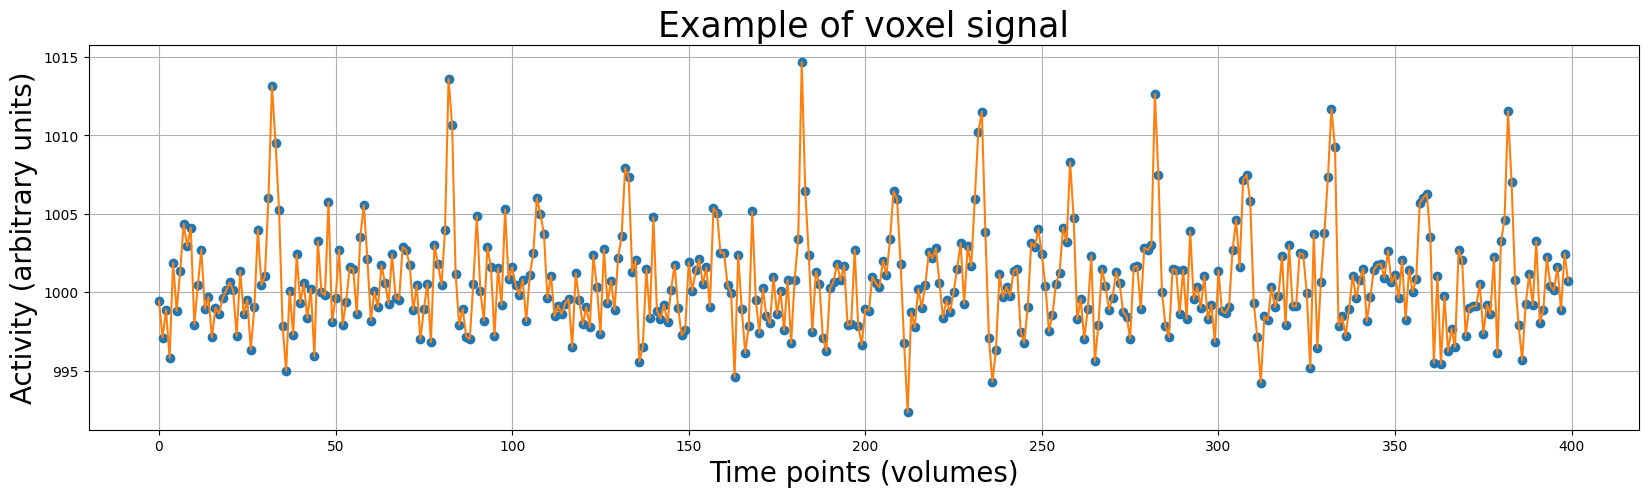

In [2]:
# Import and plot the signal.
# Data available in https://github.com/lukassnoek/NI-edu/blob/master/NI-edu/fMRI-introduction/week_2/example_voxel_signal.npy
voxel_signal = np.load('../../datasets/fMRI/example_voxel_signal.npy') # Preprocessed data
plt.figure(figsize=(20, 5))
plt.plot(voxel_signal, 'o')
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

## The Predictors

In [3]:
# Stimuli onsets (in seconds!)
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)
onsets_all = np.concatenate((onsets_squares, onsets_circles))

Shape of predictor: (800,)


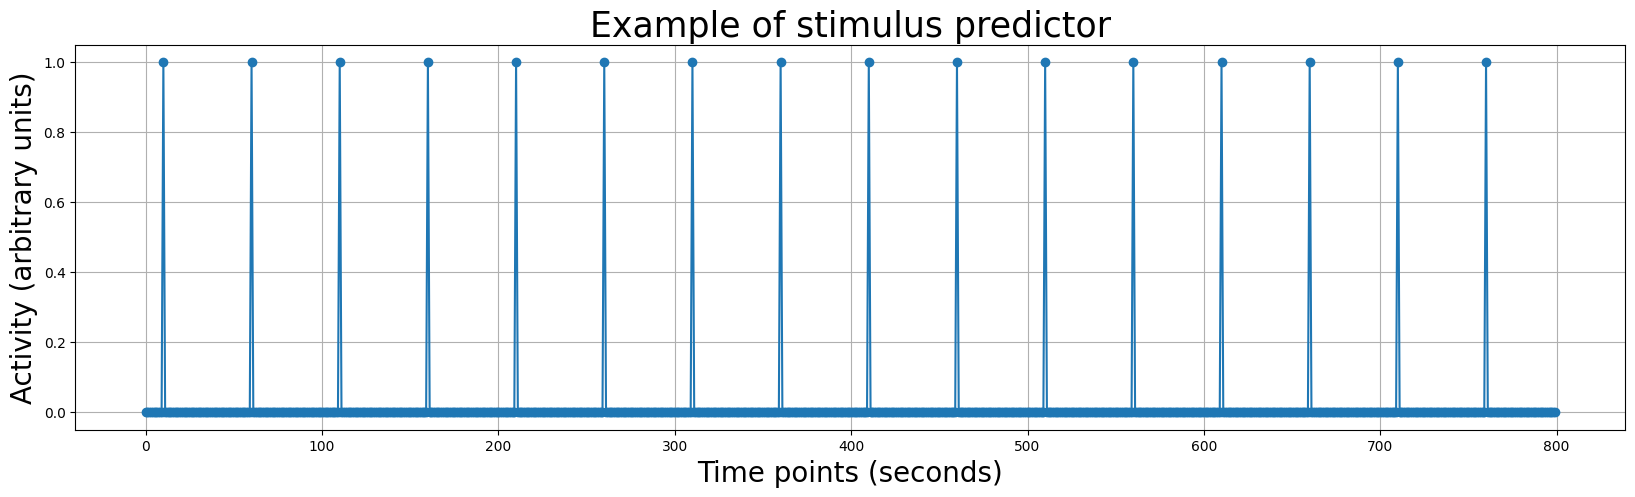

In [4]:
# Create the predictor varaible.
predictor_all = np.zeros(800)
predictor_all[onsets_all] = 1
print("Shape of predictor: %s" % (predictor_all.shape,))
plt.figure(figsize=(20, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

## Resampling

Transfer seconds to voxel time points (in this case each voxel time point is 2 seconds)

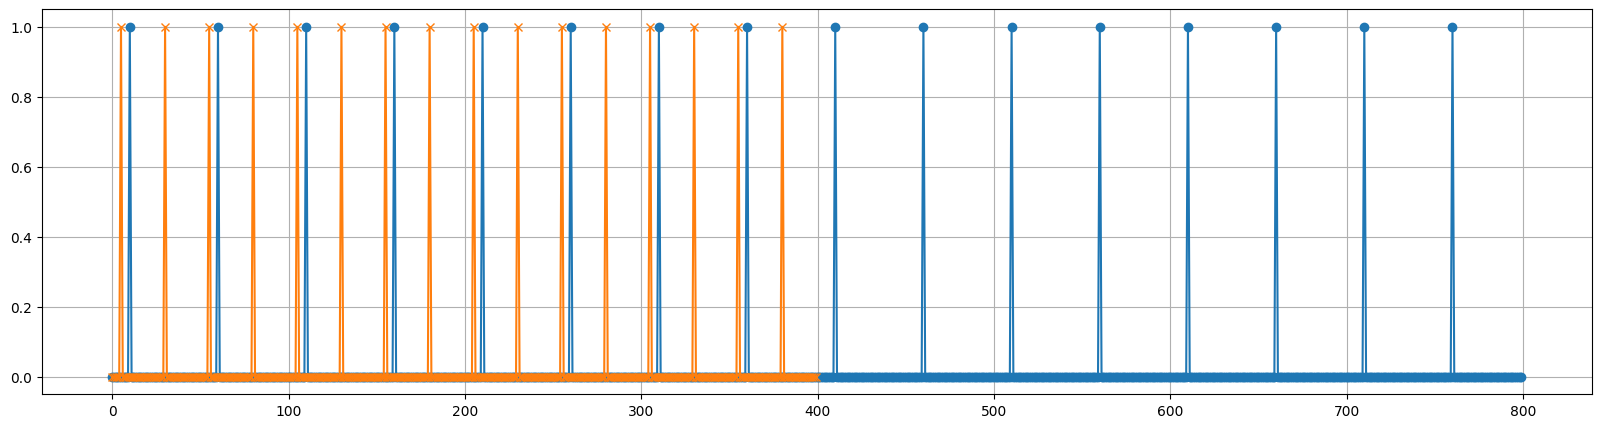

In [5]:
# Resample the predictor
from scipy.interpolate import interp1d
original_scale = np.arange(0, 800, 1)
resampler = interp1d(original_scale, predictor_all)
# Note that the resampler variable here is a function!
desired_scale = np.arange(0, 800, 2)
predictor_all_ds = resampler(desired_scale)
# Plot the resampled predictor
plt.figure(figsize=(20, 5))
plt.plot(predictor_all, marker='o',alpha=1)
plt.plot(predictor_all_ds, marker='x',alpha=1)
plt.grid()
plt.show()

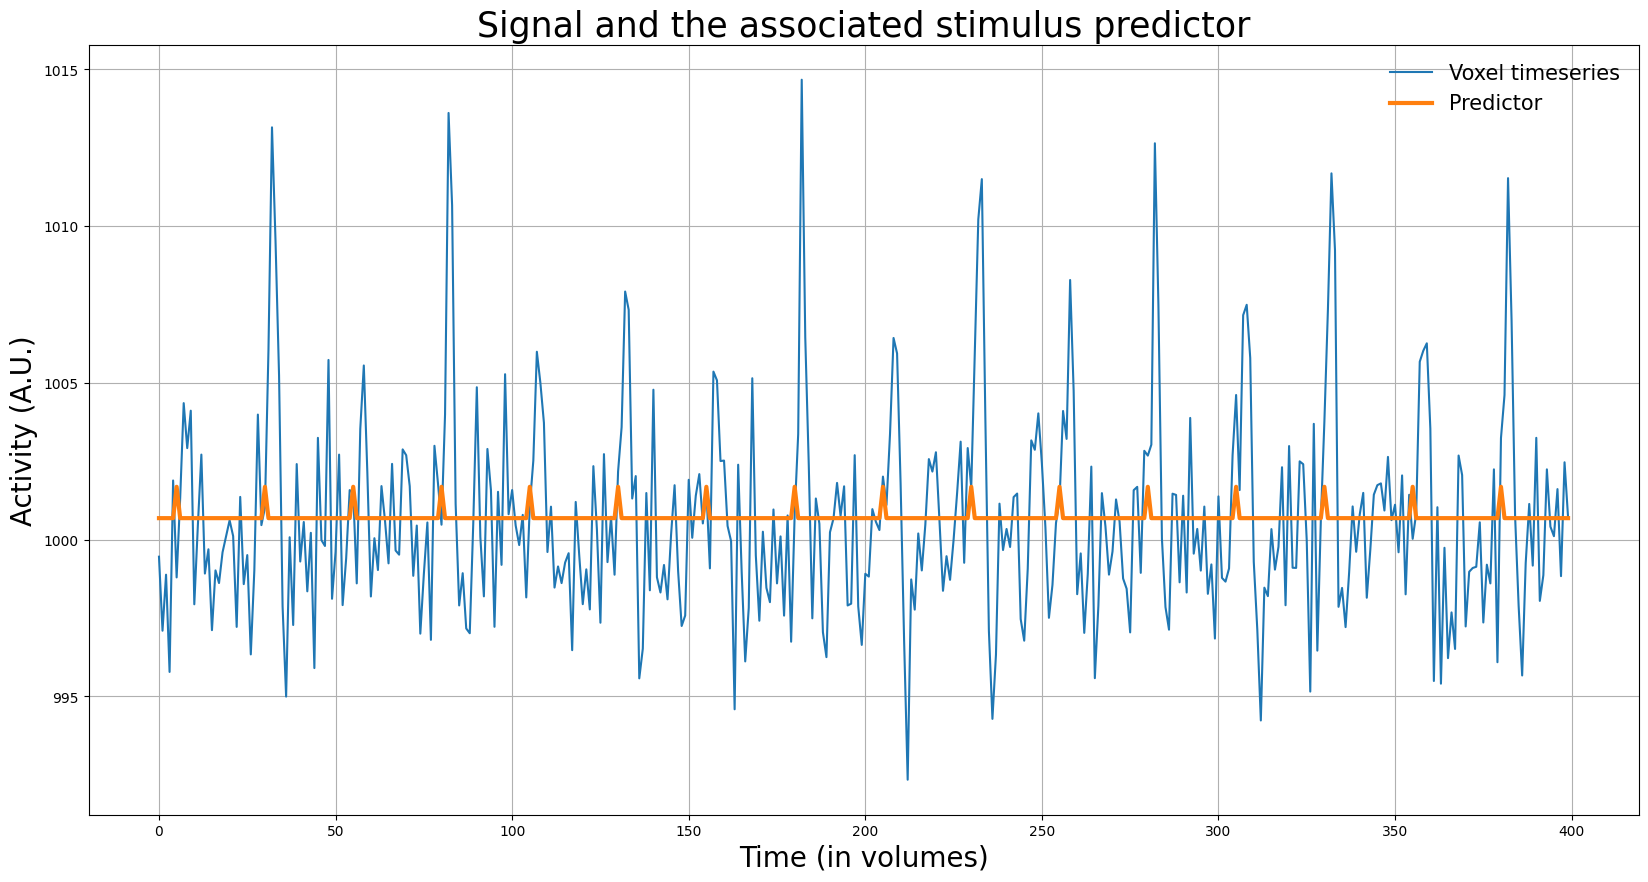

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(voxel_signal)
plt.plot(predictor_all_ds+ voxel_signal.mean() , lw=3)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right',
frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

## Modeling

In [7]:
# Fit a regresison model to the predictor and target signal.
predictor_all_ds = predictor_all_ds[:, np.newaxis]
icept = np.ones((predictor_all_ds.size, 1))
X_simple = np.hstack((icept, predictor_all_ds))
betas_simple = np.linalg.inv(X_simple.T @ X_simple) @ X_simple.T @ voxel_signal
y_hat_simple = X_simple[:, 0] * betas_simple[0] + X_simple[:, 1] * betas_simple[1]
print(betas_simple)
numerator = np.sum((voxel_signal - y_hat_simple) ** 2)
denominator = np.sum((voxel_signal - np.mean(voxel_signal)) ** 2)
r_squared = 1 - numerator / denominator
print('The R² value is: %.3f' % r_squared)

[1000.64701684    1.02307437]
The R² value is: 0.004


Not good Model ^

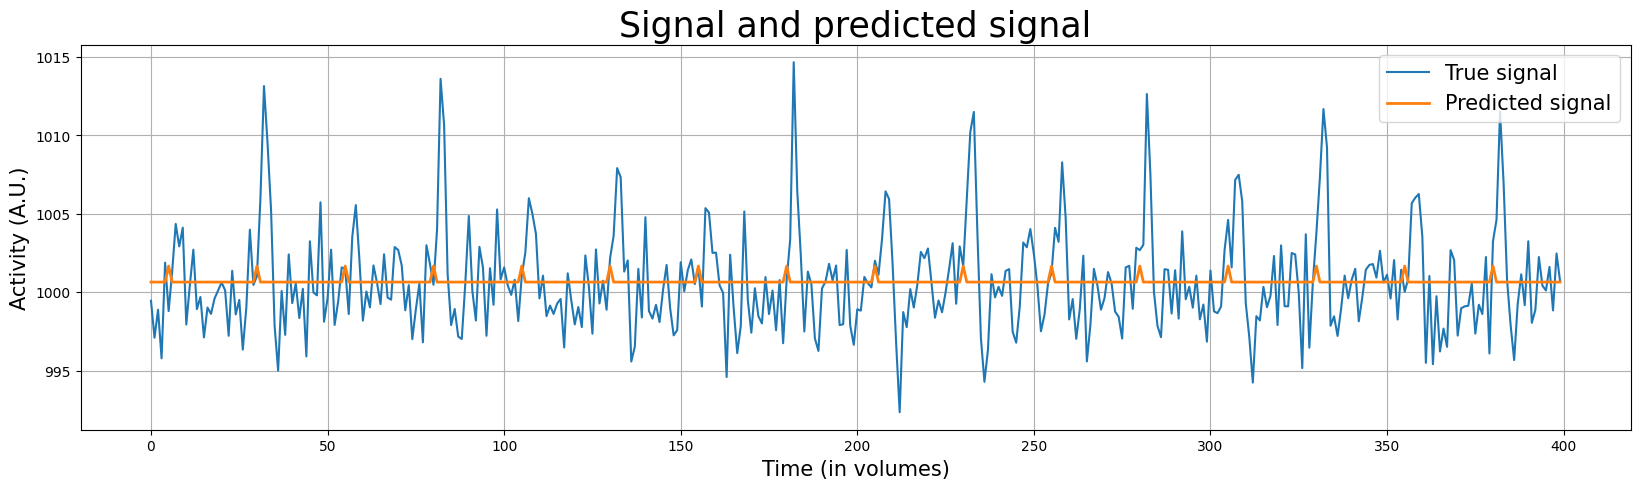

In [8]:
# Plot the true signal vs predicted signal
plt.figure(figsize=(20, 5))
plt.plot(voxel_signal)
plt.plot(y_hat_simple, lw=2)
plt.xlabel('Time (in volumes)', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.legend(['True signal', 'Predicted signal'], loc='upper right', fontsize=15)
plt.title("Signal and predicted signal", fontsize=25)
plt.grid()
plt.show()

Time values are not aligned which is why the model results are bad.

## The canonical HRF (Lecture 25)

In [9]:
# Create a canonical HRF function
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
TR = 2 # Repetition Time
# It is important to make sure that your HRF is on the same timescale as our design (predictors).
osf = 2 # Oversampling Factor
length_hrf = 32 # Length of HRF in seconds
canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf,
onset=0)
canonical_hrf /= canonical_hrf.max() # Normalize HRF to have a maximum of one.
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 32


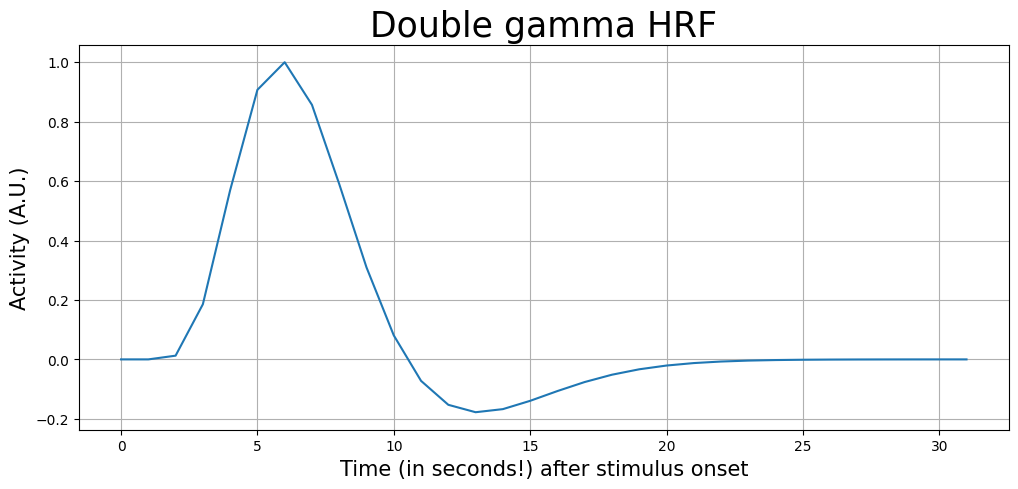

In [10]:
# Plot the HRF Function
t = np.arange(0, canonical_hrf.size)
plt.figure(figsize=(12, 5))
plt.plot(t, canonical_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

## Convolution

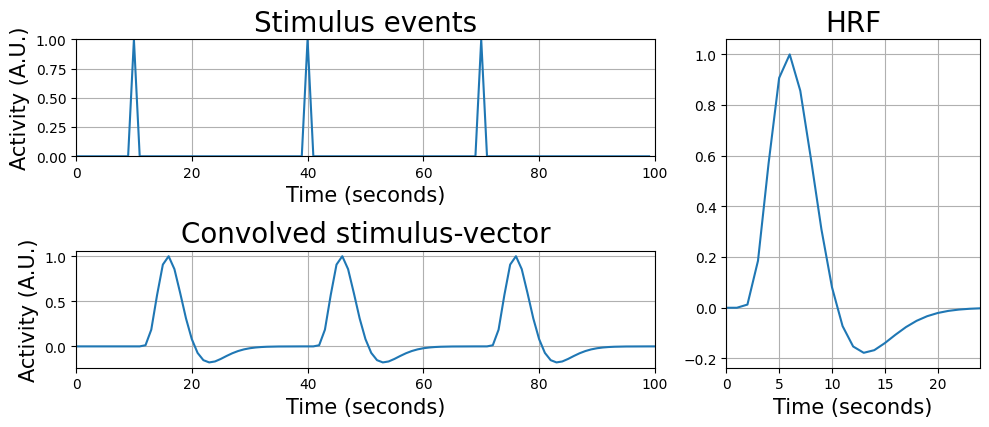

In [11]:
# Convolve the HRF function with a random onset vector of length 100 with three stimulus presentations: at t = 10, t = 40, and t = 70.
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1
plt.figure(figsize=(10, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()
plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()
convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf)
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

In [12]:
# Convolve HRF with our predictor from the last lecture.
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710],
dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760],
dtype=int)
onsets_all = np.concatenate((onsets_squares, onsets_circles))
predictor_all = np.zeros(800)
predictor_all[onsets_all] = 1
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)
print("The shape of the convolved predictor after convolution: %s" %
(predictor_conv.shape,))
# After convolution, we also neem to "trim" off some excess values from the convolved signal
predictor_conv = predictor_conv[:predictor_all.size]
print("After trimming, the shape is: %s" % (predictor_conv.shape,))
# And we have to add a new axis again to go from shape (N,) to (N, 1), which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]
print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (831,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


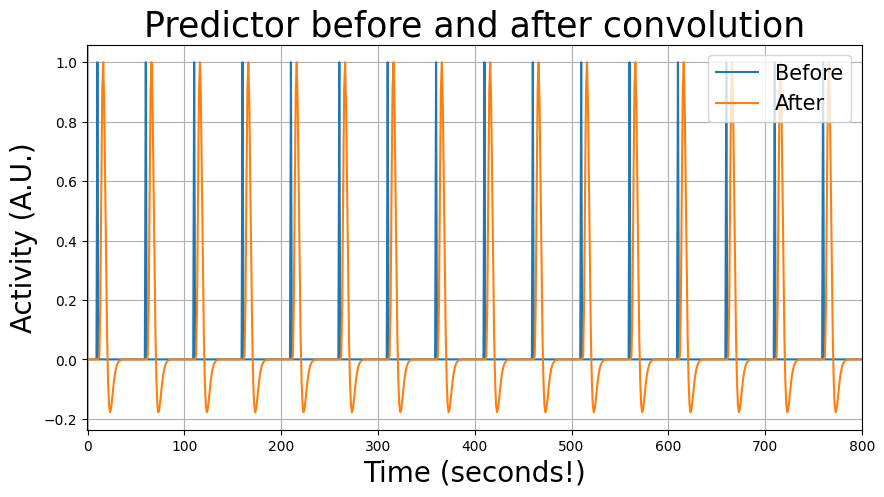

In [13]:
# Plot the convolved signal.
plt.figure(figsize=(10, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

## Resampling

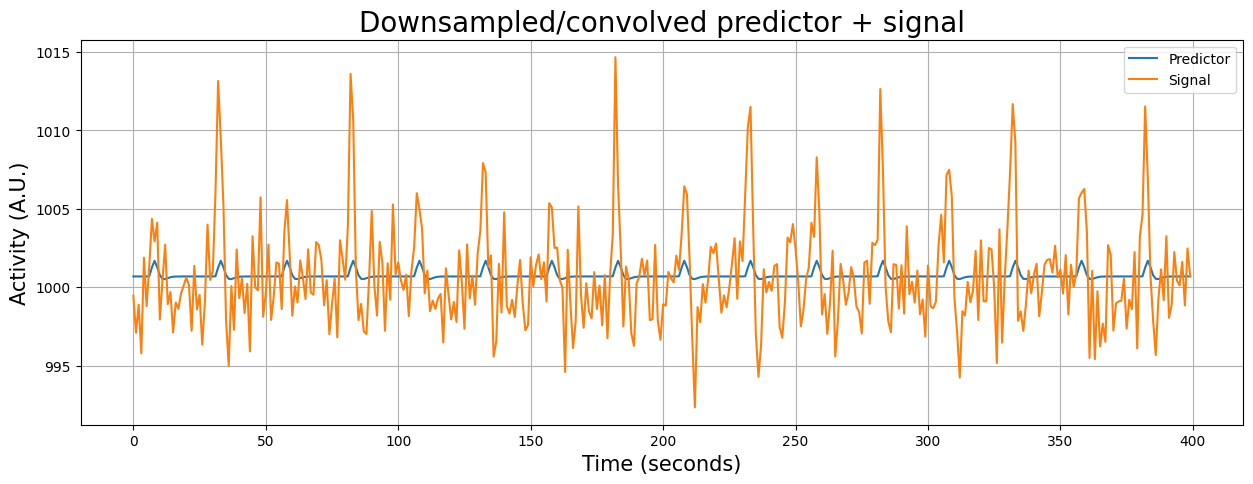

In [14]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 800)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))
desired_scale = np.arange(0, 800, 2)
predictor_conv_ds = resampler(desired_scale)
plt.figure(figsize=(15, 5))
plt.plot(predictor_conv_ds + voxel_signal.mean())
plt.plot(voxel_signal)
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['Predictor', 'Signal'])
plt.show()

## Fitting an HRF-informed model

In [15]:
# Fit two models, one with the convolved predictor and one without. Compare the plot of fitted models.
from numpy.linalg import inv
original_scale = np.arange(0, 800, 1) # from 0 to 800 seconds
resampler = interp1d(original_scale, predictor_all)
desired_scale = np.arange(0, 800, 2)
predictor_all_ds = resampler(desired_scale)
predictor_all_ds = predictor_all_ds[:, np.newaxis]
icept = np.ones((predictor_all_ds.size, 1))
X_simple = np.hstack((icept, predictor_all_ds))
predictor_conv_ds = predictor_conv_ds[:, np.newaxis]
intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal

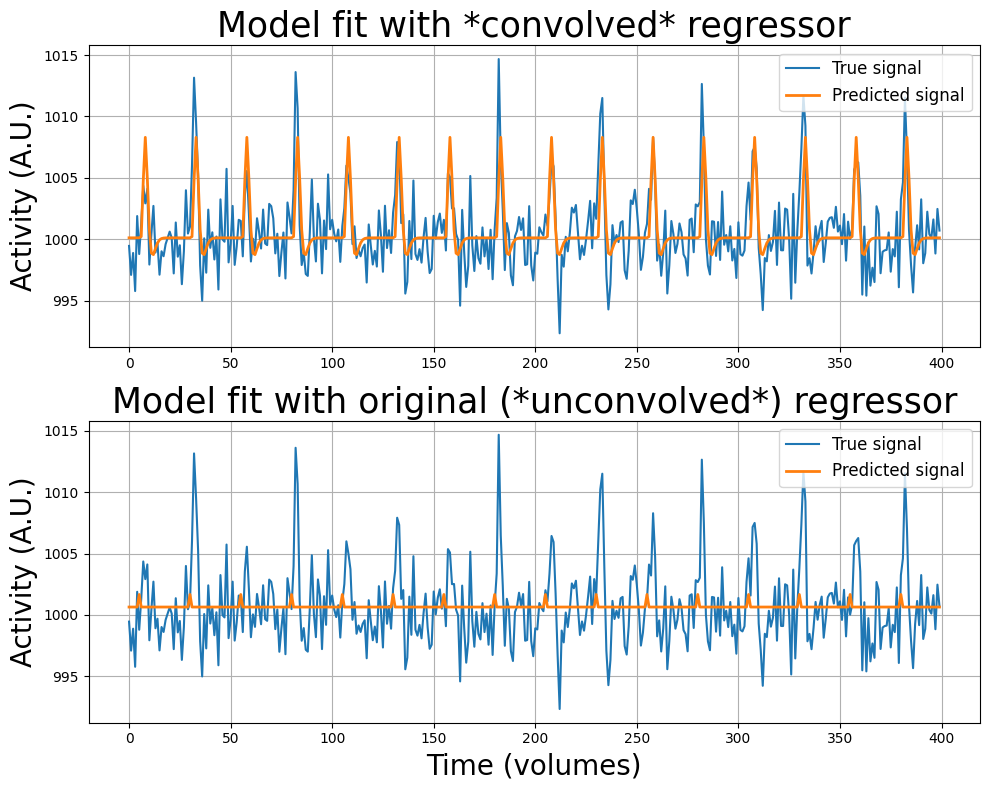

The beta-parameter of our stimulus-predictor is now: 8.181
... which is 7.997 times larger than the beta of our original beta (based on the unconvolved predictors)!


In [16]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv @ betas_conv, lw=2)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
betas_simple = np.array([1000.64701684, 1.02307437])
plt.plot(X_simple @ betas_simple, lw=2)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()
print('The beta-parameter of our stimulus-predictor is now: %.3f' % betas_conv[1])
print('... which is %.3f times larger than the beta of our original '
'beta (based on the unconvolved predictors)!' % (betas_conv[1] / betas_simple[1]))

## R^2 of Convolutional HRF Model

In [17]:
y_hat_simple = X_conv[:, 0] * betas_conv[0] + X_conv[:, 1] * betas_conv[1]
print(betas_conv)
numerator = np.sum((voxel_signal - y_hat_simple) ** 2)
denominator = np.sum((voxel_signal - np.mean(voxel_signal)) ** 2)
r_squared = 1 - numerator / denominator
print('The R² value is: %.3f' % r_squared)

[1000.11740052    8.18127018]
The R² value is: 0.419


# T-Test (Lecture 26)

• condition 1: images of male faces with a happy expression

• condition 2: images of male faces with a sad expression

• condition 3: images of male faces with a neutral expression

• condition 4: images of female faces with a happy expression

• condition 5: images of female faces with a sad expression

• condition 6: images of female faces with a neutral expression

In [18]:
# Import the packages and data
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
# Data available at https://github.com/lukassnoek/NI-edu/blob/master/NI-edu/fMRI-introduction/week_3/data_contrast_example.npz
data = np.load('../../datasets/fMRI/data_contrast_example.npz')
X, y = data['X'], data['y']
print("Shape of X: %s" % (X.shape,))
print("Shape of y: %s" % (y.shape,))

Shape of X: (100, 7)
Shape of y: (100,)


In [19]:
betas = inv(X.T @ X) @ X.T @ y
betas = betas.squeeze()
print("Betas corresponding to our 6 conditions (and intercept):\n%r" % betas.T)

Betas corresponding to our 6 conditions (and intercept):
array([ 0.08208567, -0.21982422, -0.16284892,  0.53208935,  0.26214462,
        0.38945094,  0.21565532])


In [20]:
# Again, we'd want to test whether the beta of "male_sad" is different from 0
contrast_vector = np.array([0, 0, 1, 0, 0, 0, 0])
contrast = (betas * contrast_vector).sum()
#we simply element wise multiply the contrast-vector with the betas and sum it!
print('The beta-contrast is: %.3f' % contrast)

The beta-contrast is: -0.163


In [21]:
# male sad faces > male happy faces
contrast_vector = np.array([0, -1, 1, 0, 0, 0, 0])
contrast = (betas * contrast_vector).sum()
print('The contrast between beta 2 and beta 1 is: %.3f' % contrast)
print('This is exactly the same as beta[2] - beta[1]: %.3f' % (betas[2]-betas[1]))

The contrast between beta 2 and beta 1 is: 0.057
This is exactly the same as beta[2] - beta[1]: 0.057


In [22]:
# male faces > female faces
contrast_vector = [0, 1, 1, 1, -1, -1, -1]
male_female_contrast = (contrast_vector * betas).sum()
print("Male - female contrast (regardless of expression): %.2f" %
male_female_contrast)

Male - female contrast (regardless of expression): -0.72


In [23]:
# Emotion (regardless of which emotion, i.e., regardless of sad/happy) - neutral
contrast_vector = np.array([0, 1, 1, -2, 1, 1, -2])
emo_neutral_contrast = (contrast_vector * betas).sum()
print("Emotion - neutral contrast (regardless of which emotion): %.2f" %
emo_neutral_contrast)

Emotion - neutral contrast (regardless of which emotion): -1.23


In [24]:
def design_variance(X, which_predictor=1):
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.inv(X.T.dot(X))).dot(c.T)
    return des_var

In [25]:
# E.g., get design-variance of happy/male - sad/male
c_vec = np.array([0, 1, -1, 0, 0, 0, 0]) # our contrast vector!
dvar = design_variance(X, which_predictor=c_vec) # pass c_vec to which_predictor
print("Design variance of happy/male - sad/male: %.3f" % dvar)
design_variance_new = design_variance(X, c_vec)
beta_new = inv(X.T @ X) @ X.T @ y
y_hat_new = X @ beta_new
N = y.size
P = X.shape[1]
df = (N - P)
sigma_hat = np.sum((y - y_hat_new) ** 2) / df
t_new = beta_new[1] / np.sqrt(sigma_hat * design_variance_new)
print("The t-value for the weight-parameter (beta = %.3f) is: %.3f" %
(beta_new[1], t_new))

Design variance of happy/male - sad/male: 0.024
The t-value for the weight-parameter (beta = -0.220) is: -2.013
